In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# A/B Testing: Comparing Two Samples

In [2]:
births = Table.read_table('data/baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


/opt/conda/lib/python3.9/site-packages/datascience/tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


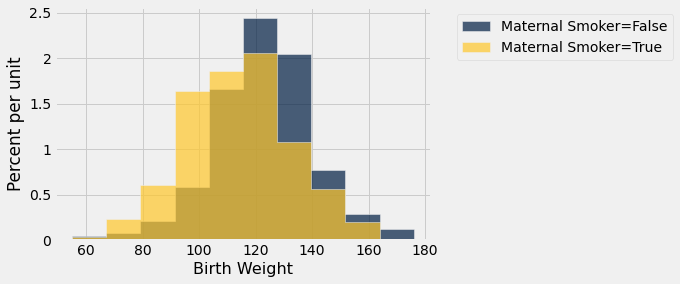

In [5]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

In [10]:
births.sort('Maternal Height')

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
146,263,39,53,110,True
141,281,29,54,156,True
105,270,22,56,93,False
99,249,31,57,98,True
146,280,26,58,106,False
107,244,20,58,97,False
108,268,22,58,112,True
131,308,30,58,150,True
116,286,22,58,105,True
107,268,37,58,112,True


## Test Statistic


In [11]:
# Use the .group method to compute the average for each group

means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [12]:
# Use the table that results from using .group
# to determine the value of the observed test statistic

means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [13]:
# Write a function that could calculate the statistic
# but is flexible enough to work on any table when you
# specify the column label that contains numerical values
# that you want to average, and the grouping label

def difference_of_means(table, label, group_label):

    # create table with only the two relevant columns
    reduced = table.select(label, group_label)  
    
    # create table containing group means
    means_table = reduced.group(group_label, np.average)
    
    # pull just the column/array with the group means
    # use .column(1) since predicted the label is hard
    means = means_table.column(1)
    
    # return the difference between the two elements
    return means.item(1) - means.item(0)

In [14]:
# Use the function to calculate the observed statistic

difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

In [15]:
# Since the function provides flexibility, look at a few other variables

difference_of_means(births, 'Gestational Days', 'Maternal Smoker')

-1.9765223882870941

In [16]:
difference_of_means(births, 'Maternal Age', 'Maternal Smoker')

-0.8076725017901509

In [17]:
difference_of_means(births, 'Maternal Height', 'Maternal Smoker')

0.09058914941267915

# Random Permutation (Shuffling)

In [18]:
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))
letters

Letter
a
b
c
d
e


In [22]:
letters.sample()

Letter
d
b
c
a
d


In [26]:
letters.sample(with_replacement = False)

Letter
b
a
c
d
e


In [27]:
shuffled_letters = letters.sample(with_replacement = False).column(0)
letters.with_column('Shuffled', shuffled_letters)

Letter,Shuffled
a,a
b,b
c,d
d,c
e,e


# Simulation Under Null Hypothesis

In [28]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [40]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False
                                                ).column('Maternal Smoker')

In [41]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,False
True,108,False
False,136,True
False,138,False
False,132,False
False,120,False
True,143,False
False,140,False


In [42]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

1.1937382878559362

In [36]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Permutation Test

In [43]:
# Write a function to complete one simulated statistic
#Delete for future classes

def one_simulated_difference(table, label, group_label):

    # select array of shuffled labels as an array
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    
    # add in the shuffled labels as a new column to the provided table
    shuffled_table = table.select(label).with_column('Shuffled Label', shuffled_labels)
    
    # return the difference of the means using the shuffled labels
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   

In [44]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

-0.6914727973551464

In [45]:
# Simulate 2500 times and store statistics in an array

differences = make_array()

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


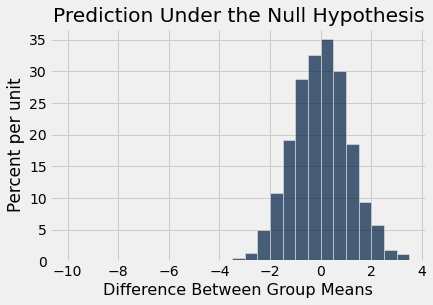

In [46]:
Table().with_column('Difference Between Group Means', differences).hist(bins=np.arange(-10, 4, 0.5))
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

## What About Gestational Days?

In [47]:
observed_difference = difference_of_means(births, 'Gestational Days', 'Maternal Smoker')

differences = make_array()

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Gestational Days', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -1.9765223882870941


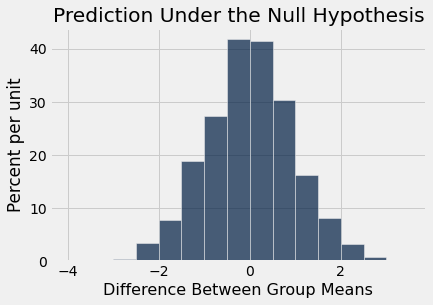

In [48]:
Table().with_column('Difference Between Group Means', differences).hist(bins=np.arange(-4, 4, 0.5))
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

In [50]:
sum(differences <= observed_difference) / 2500


0.0204